In [10]:
import pandas as pd
import numpy as np
from scipy.special import erfc
from scipy.stats import norm
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from catboost import Pool, CatBoostClassifier 

import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()

In [11]:
df = pd.read_csv('/Users/anshilina/Downloads/Maternal Health Risk Data Set.csv')

In [12]:
df.shape

(1014, 7)

In [13]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [14]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1014.0,NaN,NaN,NaN,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,NaN,NaN,NaN,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,NaN,NaN,NaN,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,NaN,NaN,NaN,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,NaN,NaN,NaN,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,NaN,NaN,NaN,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0
RiskLevel,1014,3,low risk,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


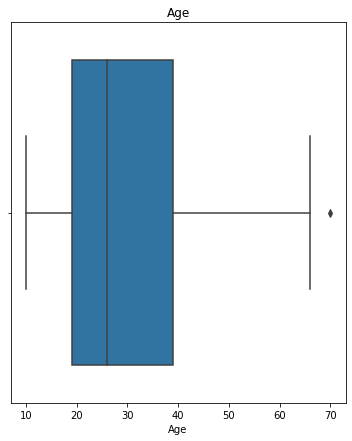

In [15]:
plt.figure(figsize=(6, 7))
sns.boxplot(df['Age'])
plt.title('Age');

In [16]:
df.loc[df['Age'] > 66]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
338,70,85,60,6.9,102.0,70,low risk


In [17]:
def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)                # Area normal dist.   
    return prob < criterion       # Use boolean array outside this function

In [18]:
df[chauvenet(df["Age"].values)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
322,65,90,60,6.9,98.0,70,low risk
326,66,85,60,6.9,98.0,86,low risk
338,70,85,60,6.9,102.0,70,low risk
339,65,120,90,6.9,103.0,76,low risk
435,65,130,80,15.0,98.0,86,high risk


In [19]:
df = df.loc[~df.index.isin(df[chauvenet(df["Age"].values)].index)].copy()

In [20]:
df['BodyTemp'] = (df['BodyTemp'] - 32) * 5/9

In [21]:
df['BodyTemp'].describe()

count    1009.000000
mean       37.033036
std         0.757473
min        36.666667
25%        36.666667
50%        36.666667
75%        36.666667
max        39.444444
Name: BodyTemp, dtype: float64

In [22]:
df['MeanBP'] = (df['SystolicBP'] + 2*df['DiastolicBP'])/3

In [23]:
df[['MeanBP', 'SystolicBP', 'DiastolicBP']].head()

,MeanBP,SystolicBP,DiastolicBP
0,96.666667,130,80
1,106.666667,140,90
2,76.666667,90,70
3,103.333333,140,85
4,80.000000,120,60


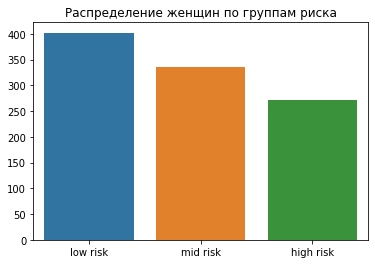

In [24]:
sns.barplot(data = df, x=df['RiskLevel'].value_counts().index, y=df['RiskLevel'].value_counts().values)
plt.title('Распределение женщин по группам риска');

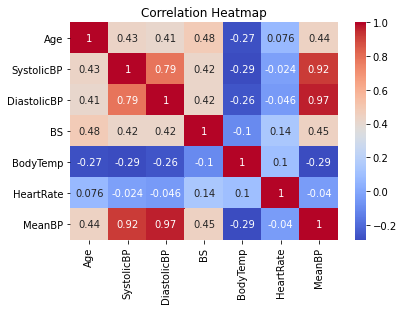

In [25]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Сильная корреляция MeanBP, SystolicBP, DiastolicBP. Не стоит использовать линейные модели.

In [26]:
features, target = df.drop('RiskLevel', axis=1), df['RiskLevel']

In [27]:
# le = LabelEncoder()
# target_enc = le.fit_transform(target)
# le.inverse_transform([0, 1, 2])

In [28]:
def target_encoder(series):
    if series == 'high risk':
        return 2
    elif series == 'mid risk':
        return 1
    else:
        return 0

target_enc = target.apply(target_encoder)

In [29]:
features_train, features_test, target_train, target_test = train_test_split(
        features, target_enc, test_size=0.25, stratify=target, random_state=42)

### Catboost

In [30]:
train_dataset = Pool(data=features_train,
                     label=target_train)

eval_dataset = Pool(data=features_test,
                    label=target_test)

# Initialize CatBoostClassifier
cat_model = CatBoostClassifier(random_seed=42, loss_function='MultiClass', silent=True)

In [31]:
cat_grid = {'depth':[6, 9, 10, 11],
            'iterations': [100, 150, 200]} 

cat_gs = GridSearchCV(cat_model, cat_grid, cv=5)

In [32]:
cat_gs.fit(features_train, target_train)
print("Лучшие гиперпараметры:", cat_gs.best_params_)
print("Лучшая оценка на кросс-валидации:", cat_gs.best_score_)

Лучшие гиперпараметры: {'depth': 10, 'iterations': 100}
Лучшая оценка на кросс-валидации: 0.8359707215057511


### Random Forest

In [33]:
params = {
    "n_estimators": [10, 20, 50, 100],
    "criterion": ["gini", "entropy"]
}
rf = RandomForestClassifier(random_state=100)
grid = GridSearchCV(rf, params, cv=10)
grid.fit(features_train, target_train)
print("Лучшие гиперпараметры:", grid.best_params_)
print("Лучшая оценка на кросс-валидации:", grid.best_score_)

Лучшие гиперпараметры: {'criterion': 'gini', 'n_estimators': 100}
Лучшая оценка на кросс-валидации: 0.8412105263157894


In [34]:
model = grid.best_estimator_

In [35]:
filename = 'model.pkl'
pickle.dump(model, open(filename, 'wb'))

#### Tree-based (or Gini) importance

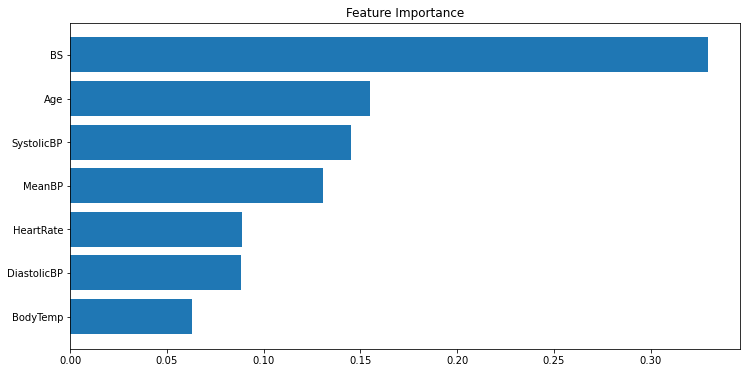

In [36]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Feature Importance');

#### Permutation importance

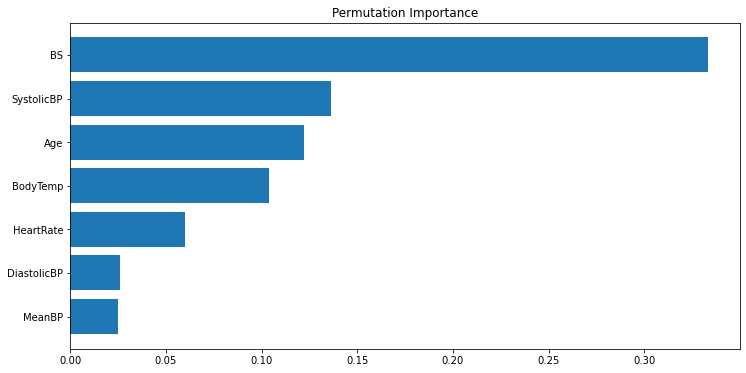

In [37]:
perm_importance = permutation_importance(model, features_train, target_train, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Permutation Importance');

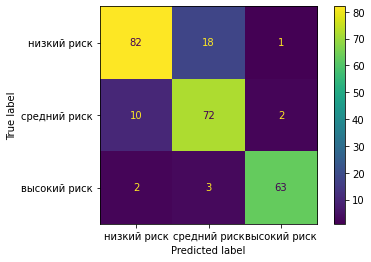

In [41]:
ConfusionMatrixDisplay(confusion_matrix(target_test, model.predict(features_test)), 
                       display_labels=['низкий риск', 'средний риск', 'высокий риск']).plot();

#### Shape

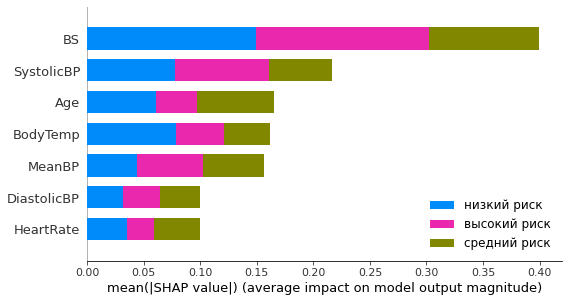

In [45]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features_train)
shap.summary_plot(shap_values, features_train.values, plot_type="bar", 
                  feature_names = features_train.columns,
                  class_names=['низкий риск', 'средний риск', 'высокий риск'])

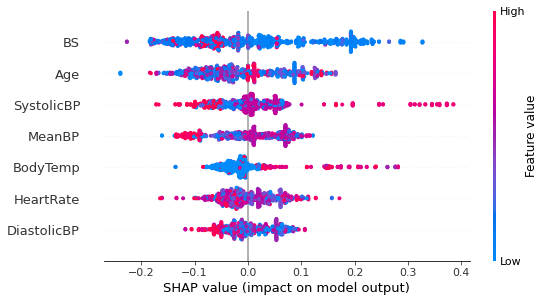

In [47]:
shap.summary_plot(shap_values[1], features_train.values, feature_names = features_train.columns)

In [49]:
features_train.reset_index(drop=True, inplace=True)

In [70]:
i = 100
shap.force_plot(explainer.expected_value[0], shap_values[0][i], 
                features_train.values[i], feature_names = features_train.columns)

Возраст уменьшает риск.

In [71]:
shap_values[0][100]

array([0.06390205, 0.07464881, 0.00401629, 0.23949568, 0.0607749 ,
       0.05291883, 0.04067201])

In [72]:
features_train.loc[features_train['Age'].index == 100]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,MeanBP
100,21,90,65,7.5,36.666667,76,73.333333


In [55]:
features_train.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'MeanBP'],
      dtype='object')

In [155]:
# https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

Неудачный вариант.

### Логистическая регрессия

In [56]:
numerical = df.select_dtypes(include=['int64', 'float64']).columns.values
num_pipe = Pipeline([('scaler', StandardScaler())])

linear_preprocessor = ColumnTransformer(
    transformers = [('num', num_pipe, numerical)], 
    remainder='passthrough')

In [57]:
model = Pipeline([('preprocessor', linear_preprocessor), 
                  ('model', LogisticRegression(multi_class='multinomial'))])
cross_val_score(model, features_train, target_train)

array([0.66447368, 0.60927152, 0.59602649, 0.64238411, 0.57615894])

In [58]:
model = Pipeline([('preprocessor', linear_preprocessor), 
                  ('model', LogisticRegression(multi_class='ovr'))])
cross_val_score(model, features_train, target_train)

array([0.64473684, 0.66887417, 0.62251656, 0.64900662, 0.60927152])

In [59]:
model.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'MeanBP'], dtype=object))])),
                ('model', LogisticRegression(multi_class='ovr'))])

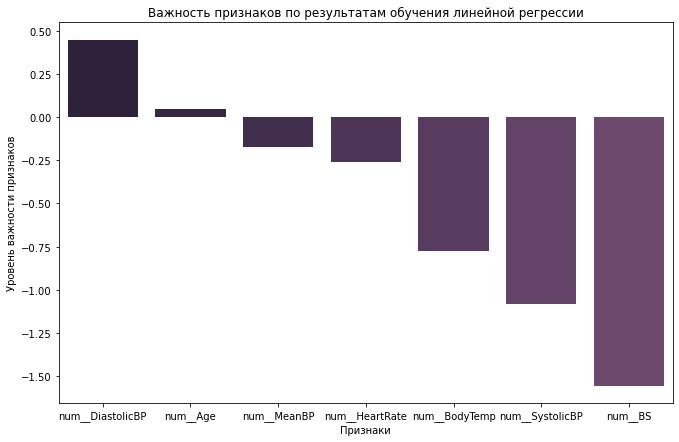

In [60]:
feature_importance = pd.DataFrame(data=model['model'].coef_[0], 
                                  index=model['preprocessor'].get_feature_names_out(),
                                  columns=['importance']) 
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(11,7))
sns.barplot(data=feature_importance,
            x=feature_importance.index,
            y=feature_importance['importance'],
            palette=sns.cubehelix_palette(23, reverse=True))
plt.xlabel('Признаки')
plt.ylabel('Уровень важности признаков')
plt.title('Важность признаков по результатам обучения линейной регрессии')
plt.show()

In [46]:
features_train[4]

KeyError: 4

In [27]:
!pip freeze > requirements.txt